In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
import numpy as np
import seaborn as sns
import tensorflow as tf

In [22]:
from environment import TradingEnvironment
from market_instance import new_market, make_investors

### Configuration for the synthetic market

In [23]:
config = {
    'num_investors': 10,
    'num_rounds_per_day': 3
}

### Our own portfolio

In [24]:
holdings = {
    'cash': 100000.00, 
    'TSLA': 300, 
    'AAPL': 200, 
    'MSFT': 400}

### Create the RL Environment

In [25]:
market = new_market()
environment = TradingEnvironment(config, holdings, market, 0.002)

## The market in action

In [26]:
for _ in range(360):
    market.open()
    daily = environment.let_others_trade()
    market.close()

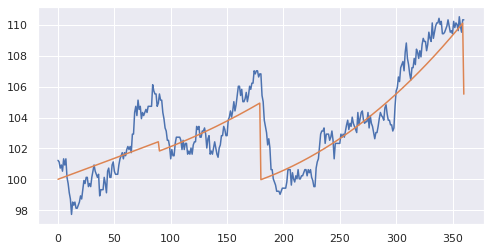

In [27]:
def plot(ticker):
    sns.set(rc={'figure.figsize':(8.0,4.0)})
    h = market.history_for(ticker)
    s = market.stocks[ticker]
    p_open, p_close, p_high, p_low = np.transpose(h)
    t = np.array(range(len(p_open)))
    sns.lineplot(t, p_open);
    sns.lineplot(t, [s.psi(tt) for tt in t]);
plot('AAPL')

## Perform an Action = Re-Balance

In [28]:
target_weights = np.array([.1, .3, .4, .2])

In [29]:
investor = environment.investor
print(investor, environment.total_wealth())
environment.act(target_weights)
print(investor, environment.total_wealth())

WB (cash: 100000.0, {'TSLA': 300, 'AAPL': 200, 'MSFT': 400}) 252387.0
WB (cash: 50295.037, {'TSLA': 711, 'AAPL': 230, 'MSFT': 345}) 252286.298


In [30]:
# slightly off-target because of integer stock counts and the trading costs.
environment.normalized_holdings()

array([0.09884702, 0.297899  , 0.40389699, 0.19935699])

### The ANN-based Trader Model

In [31]:
N_LSTM_NEURONS = 128
N_STOCKS = len(holdings)-1
BATCH_SIZE = 128
N_STEPS = 20                  # history length for the LSTM
N_OUT = N_STOCKS + 1          # stocks and cash
# current log returns, positions' weights, cash weight
N_FEATURES = N_STOCKS * 2 + 1

In [32]:
from models import LSTM_TraderModel

In [33]:
lstm_model = LSTM_TraderModel(
    n_neurons=N_LSTM_NEURONS, 
    n_steps=N_STEPS,
    n_features=N_FEATURES,
    n_out=N_OUT)

x = np.random.random(
    [BATCH_SIZE, N_STEPS, N_FEATURES]).astype(np.float32)

y = lstm_model(x) # initialize the model
test_portfolio = lstm_model.portfolio(x)
lstm_model.summary()

Model: "lstm__trader_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                multiple                  69632     
_________________________________________________________________
dense_1 (Dense)              multiple                  516       
Total params: 70,148
Trainable params: 70,148
Non-trainable params: 0
_________________________________________________________________


In [69]:
x = np.random.random(
    [1, 5, N_FEATURES]).astype(np.float32)
x

array([[[0.03567473, 0.7445087 , 0.03561487, 0.51433146, 0.6715977 ,
         0.5140916 , 0.41249952],
        [0.7741946 , 0.58633935, 0.6248548 , 0.12891488, 0.6264675 ,
         0.46672013, 0.26511735],
        [0.6070363 , 0.59503275, 0.47512424, 0.6481679 , 0.6211338 ,
         0.97728866, 0.3605696 ],
        [0.5546665 , 0.61047757, 0.7710038 , 0.25391993, 0.3184132 ,
         0.4791217 , 0.7841179 ],
        [0.89666885, 0.45568684, 0.08017183, 0.13848422, 0.39756003,
         0.19148107, 0.3124232 ]]], dtype=float32)

In [70]:
lstm_model.portfolio(x)

<tf.Tensor: id=1044, shape=(1, 4), dtype=float32, numpy=array([[0.24306141, 0.26462433, 0.2590349 , 0.23327933]], dtype=float32)>

### Observation And Reward
The observation consists of the normalized holdings and the normalized log returns of the traded assets with respect to the closing prices. 

In [85]:
obs, reward = environment.act([.2, .2, .3, .3])
print("Observations: 4x normalized holdings, 3x normalized log returns:")
print(obs)
print("Reward: %s" % reward)

Observations: 4x normalized holdings, 3x normalized log returns:
[ 0.1993516   0.19866627  0.30201939  0.29996274 -0.08842119 -0.13643058
  0.77514824]
Reward: 0.002018417869396454


Observe the time lag. This is a super-expensive method. We may need to consider parallel execution with Ray here...;-(